# Variational Autoencoder

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))

    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [165]:
class VariationalAutoencoder(object):
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # Input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()
        
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def getMeanAndSigma(self, X_sample):
        z_mean_, z_log_sigma_sq = self.sess.run((self.z_mean, self.z_log_sigma_sq), 
                                  feed_dict={self.x: X_sample})        
        return z_mean_, z_log_sigma_sq
    
    def _create_network(self):
        # Initialize weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])
        
        #print(self.z_mean.shape, self.z_log_sigma_sq.shape)
        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps)

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_recog_3,
                            n_hidden_gener_1,  n_hidden_gener_2, n_hidden_gener_3,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'h3': tf.Variable(xavier_init(n_hidden_recog_2, n_hidden_recog_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_3, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_3, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_recog_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'h3': tf.Variable(xavier_init(n_hidden_gener_2, n_hidden_gener_3)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_3, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_3, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'b3': tf.Variable(tf.zeros([n_hidden_gener_3], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder 
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        z_mean         = tf.add(tf.matmul(layer_3, weights['out_mean']),
                                biases['out_mean'])
        
        z_log_sigma_sq = tf.add(tf.matmul(layer_3, weights['out_log_sigma']), 
                                biases['out_log_sigma'])
        
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        layer_3 = self.transfer_fct(tf.add(tf.matmul(layer_2, weights['h3']), 
                                           biases['b3'])) 
        
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['out_mean']), 
                                        biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # Two loss:
        #
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        
        
        # Adding 1e-10 to avoid evaluation of log(0.0)
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        
        # average over batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)   
        
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [166]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

## Reconstruction quality

In [167]:
network_architecture = \
    dict(n_hidden_recog_1=400, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=100, # 3th layer encoder neurons
         n_hidden_gener_1=100, # 1st layer decoder neurons
         n_hidden_gener_2=200, # 2nd layer decoder neurons
         n_hidden_gener_3=400, # 3th layer decoder neurons
         n_input=784,          # MNIST data input (img shape: 28*28)
         n_z=20)               # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 192.559436951
Epoch: 0006 cost= 119.691278270
Epoch: 0011 cost= 111.840565116
Epoch: 0016 cost= 108.028469946
Epoch: 0021 cost= 105.842706160
Epoch: 0026 cost= 104.242836651
Epoch: 0031 cost= 103.134686043
Epoch: 0036 cost= 102.440753992
Epoch: 0041 cost= 101.681984184
Epoch: 0046 cost= 101.089719571
Epoch: 0051 cost= 100.728096757
Epoch: 0056 cost= 100.187025604
Epoch: 0061 cost= 100.016102392
Epoch: 0066 cost= 99.674692216
Epoch: 0071 cost= 99.321160639


In [168]:
def getImagefromDataset(num):
    xs, ys = mnist.train.next_batch(1000)
    
    xs_l = []
    
    for i in range(1000):
        if np.argmax(ys[i]) == num:
            xs_l.append(xs[i])
    
    if len(xs_l) > 0:
        return xs_l[0]
    else: 
        return None

In [281]:
def getVAEImage(num):
    imgX    = getImagefor(num)
    mu, sig = vae.getMeanAndSigma([imgX])   
    eps     = np.random.normal( 0, 1,(1, 20))
    z_      = mu + np.sqrt(np.exp(sig)) * eps
    z_mu    = np.array([z_[0]]*vae.batch_size)
    z_.shape, z_mu.shape
    x_mean  = vae.generate(z_mu)
    img     = x_mean[0].reshape(28,28)
    
    return img

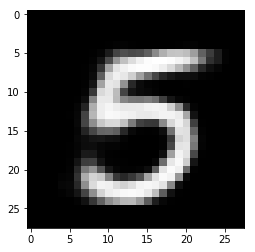

In [317]:
img = getVAEImage(5)

plt.imshow(img, cmap='gray')

In [143]:
samples = np.load('samples.npy')

In [297]:
def getListOfNumbers(sNUM):
    res = []
    for i in range(len(sNUM)):
        img = getVAEImage(int(sNUM[i]))
        res.append(img)
    return res

In [310]:
NUM = input("Enter a number : ")

Enter a number : 56894


In [311]:
input_imgs = getListOfNumbers(NUM)

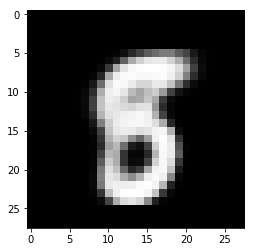

In [313]:
plt.imshow(input_imgs[0], cmap='gray')